# Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Описание услуг

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных

Данные состоят из файлов, полученных из разных источников:

contract_new.csv — информация о договоре;

personal_new.csv — персональные данные клиента;

internet_new.csv — информация об интернет-услугах;

phone_new.csv — информация об услугах телефонии.


Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

- customer_id	- киент
- begin_date - дата начала
- end_date - дата окончания
- type - тип оплаты
- paperless_billing -	электронный чек
- payment_method - способ оплаты
- total_charges - общие расходы
- gender - пол
- partner - семейное положение
- dependents - иждивенцы
- internet_service - интернет поддержка
- online_security - охрана
- online_backup -	облако
- device_protection -	гарантийное обслуживание
- tech_support - техническая поддержка
- streaming_tv - подписка ТВ
- streaming_movies - подписка фильмы
- multiple_lines - многокональный


**Цель проекта:** спрогнозировать уход клиента и определить факторы, влияющие на отток клиентов

ПЛАН:

1. Подготовка данных
- Загрузка и ознакомление с данными
- преобразование данных:
- приведение к змеиному синтаксису и к соответствующим типам данных
- объединение данных в единый датафрейм
- выделение целевого признака
- работа с пропусками дубликатами
- EDA
- определение RANDOM_STATE = 310723
- Разделение на выборки (3:1)
- Кодирование (OrdinalEncoder)
- Удаление признаков

2. Обучение моделей
- Подбор гиперпараметров на кроссвалидации с GridSearchCV для:

1) Random Forest
2) LightGBM
3) CatBoost

- Обучение моделей и выбор лучшей на основании лучшего показателя (по метрике на кроссвалидации model.bestscore после GridSearchCV)

3. Тестирование лучшей модели по метрике ROC-AUC на тестовой выборке (+ вывести ROC-кривую, посчитать accuracy, вывести матрицу ошибок и важность признаков)

4. Выводы и рекомендации для бизнеса

**Необходимый итоговый результат:** Сделать модель с итоговым значением roc-auc не мение 0,85.

### Подготовка данных

Используемые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

import itertools

Установливать библиотеки буждем отдельно

In [ ]:
#!pip install xgboost

In [ ]:
!pip install phik

In [ ]:
!pip install missingno

In [ ]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
import missingno as msno

Напишем функцию для первичной проверки данных

In [ ]:
# Напишем функцию для первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T)


    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())

    print('\033[1m' + '\nНазвания колонок:'+ '\033[0m')
    for column in data_df.columns:
        print(column)

#### Загрузим данные

In [ ]:

try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

##### df_contract

In [ ]:
check_data(df_contract)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75



Описание категориальных данных:


,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
BeginDate,7043,77,2014-02-01,366
EndDate,7043,67,No,5942
Type,7043,3,Month-to-month,3875
PaperlessBilling,7043,2,Yes,4171
PaymentMethod,7043,4,Electronic check,2365
TotalCharges,7043,6658,,11



Вывод уникальных значений по каждому категориаьному признаку:
_customerID


7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

_BeginDate


2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

_EndDate


No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

_Type


Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

_PaperlessBilling


Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

_PaymentMethod


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

_TotalCharges


           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: TotalCharges, Length: 6658, dtype: int64


Названия колонок:
customerID
BeginDate
EndDate
Type
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges


##### df_personal

In [ ]:
check_data(df_personal)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0



Описание категориальных данных:


,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933



Вывод уникальных значений по каждому категориаьному признаку:
_customerID


7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

_gender


Male      3555
Female    3488
Name: gender, dtype: int64

_Partner


No     3641
Yes    3402
Name: Partner, dtype: int64

_Dependents


No     4933
Yes    2110
Name: Dependents, dtype: int64


Названия колонок:
customerID
gender
SeniorCitizen
Partner
Dependents


##### df_internet

In [ ]:
check_data(df_internet)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Описание количественных данных:


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785



Описание категориальных данных:


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785



Вывод уникальных значений по каждому категориаьному признаку:
_customerID


7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64

_InternetService


Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

_OnlineSecurity


No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

_OnlineBackup


No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

_DeviceProtection


No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

_TechSupport


No     3473
Yes    2044
Name: TechSupport, dtype: int64

_StreamingTV


No     2810
Yes    2707
Name: StreamingTV, dtype: int64

_StreamingMovies


No     2785
Yes    2732
Name: StreamingMovies, dtype: int64


Названия колонок:
customerID
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies


##### df_phone

In [ ]:
check_data(df_phone)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Описание количественных данных:


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390



Описание категориальных данных:


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390



Вывод уникальных значений по каждому категориаьному признаку:
_customerID


5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64

_MultipleLines


No     3390
Yes    2971
Name: MultipleLines, dtype: int64


Названия колонок:
customerID
MultipleLines


Итак, можно сделать первые выводы. Пропуски и дубликаты отсутствую, это уже радует. Нам предоставлено четыре дата сета, в двух одинаковое количество столбцов 7043 (contract & personal), internet 5517 и phone 6361 соответственно.

#### Объединим данные

In [ ]:
df = df_contract.merge(df_personal, on='customerID', how='left')
df = df.merge(df_internet, on='customerID', how='left')
df = df.merge(df_phone, on='customerID', how='left')

In [ ]:
# приведем данные к PEP-8
df.columns = (df.columns
                  .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                  .str.lower())
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

все хорошо, код сработал.

In [ ]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  t

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00



Описание категориальных данных:


,count,unique,top,freq
customer_id,7043,7043,7590-VHVEG,1
begin_date,7043,77,2014-02-01,366
end_date,7043,67,No,5942
type,7043,3,Month-to-month,3875
paperless_billing,7043,2,Yes,4171
payment_method,7043,4,Electronic check,2365
total_charges,7043,6658,,11
gender,7043,2,Male,3555
partner,7043,2,No,3641
dependents,7043,2,No,4933



Вывод уникальных значений по каждому категориаьному признаку:
_customer_id


7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customer_id, Length: 7043, dtype: int64

_begin_date


2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64

_end_date


No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

_type


Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

_paperless_billing


Yes    4171
No     2872
Name: paperless_billing, dtype: int64

_payment_method


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

_total_charges


           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: total_charges, Length: 6658, dtype: int64

_gender


Male      3555
Female    3488
Name: gender, dtype: int64

_partner


No     3641
Yes    3402
Name: partner, dtype: int64

_dependents


No     4933
Yes    2110
Name: dependents, dtype: int64

_internet_service


Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

_online_security


No     3498
Yes    2019
Name: online_security, dtype: int64

_online_backup


No     3088
Yes    2429
Name: online_backup, dtype: int64

_device_protection


No     3095
Yes    2422
Name: device_protection, dtype: int64

_tech_support


No     3473
Yes    2044
Name: tech_support, dtype: int64

_streaming_tv


No     2810
Yes    2707
Name: streaming_tv, dtype: int64

_streaming_movies


No     2785
Yes    2732
Name: streaming_movies, dtype: int64

_multiple_lines


No     3390
Yes    2971
Name: multiple_lines, dtype: int64


Названия колонок:
customer_id
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges
gender
senior_citizen
partner
dependents
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies
multiple_lines


Объединение данных прошло успешно. У нас появились пропуски, все как мы любим. Далее посмотрим более детально на наши данные, к данному пункту думаю еще придется вернуться.

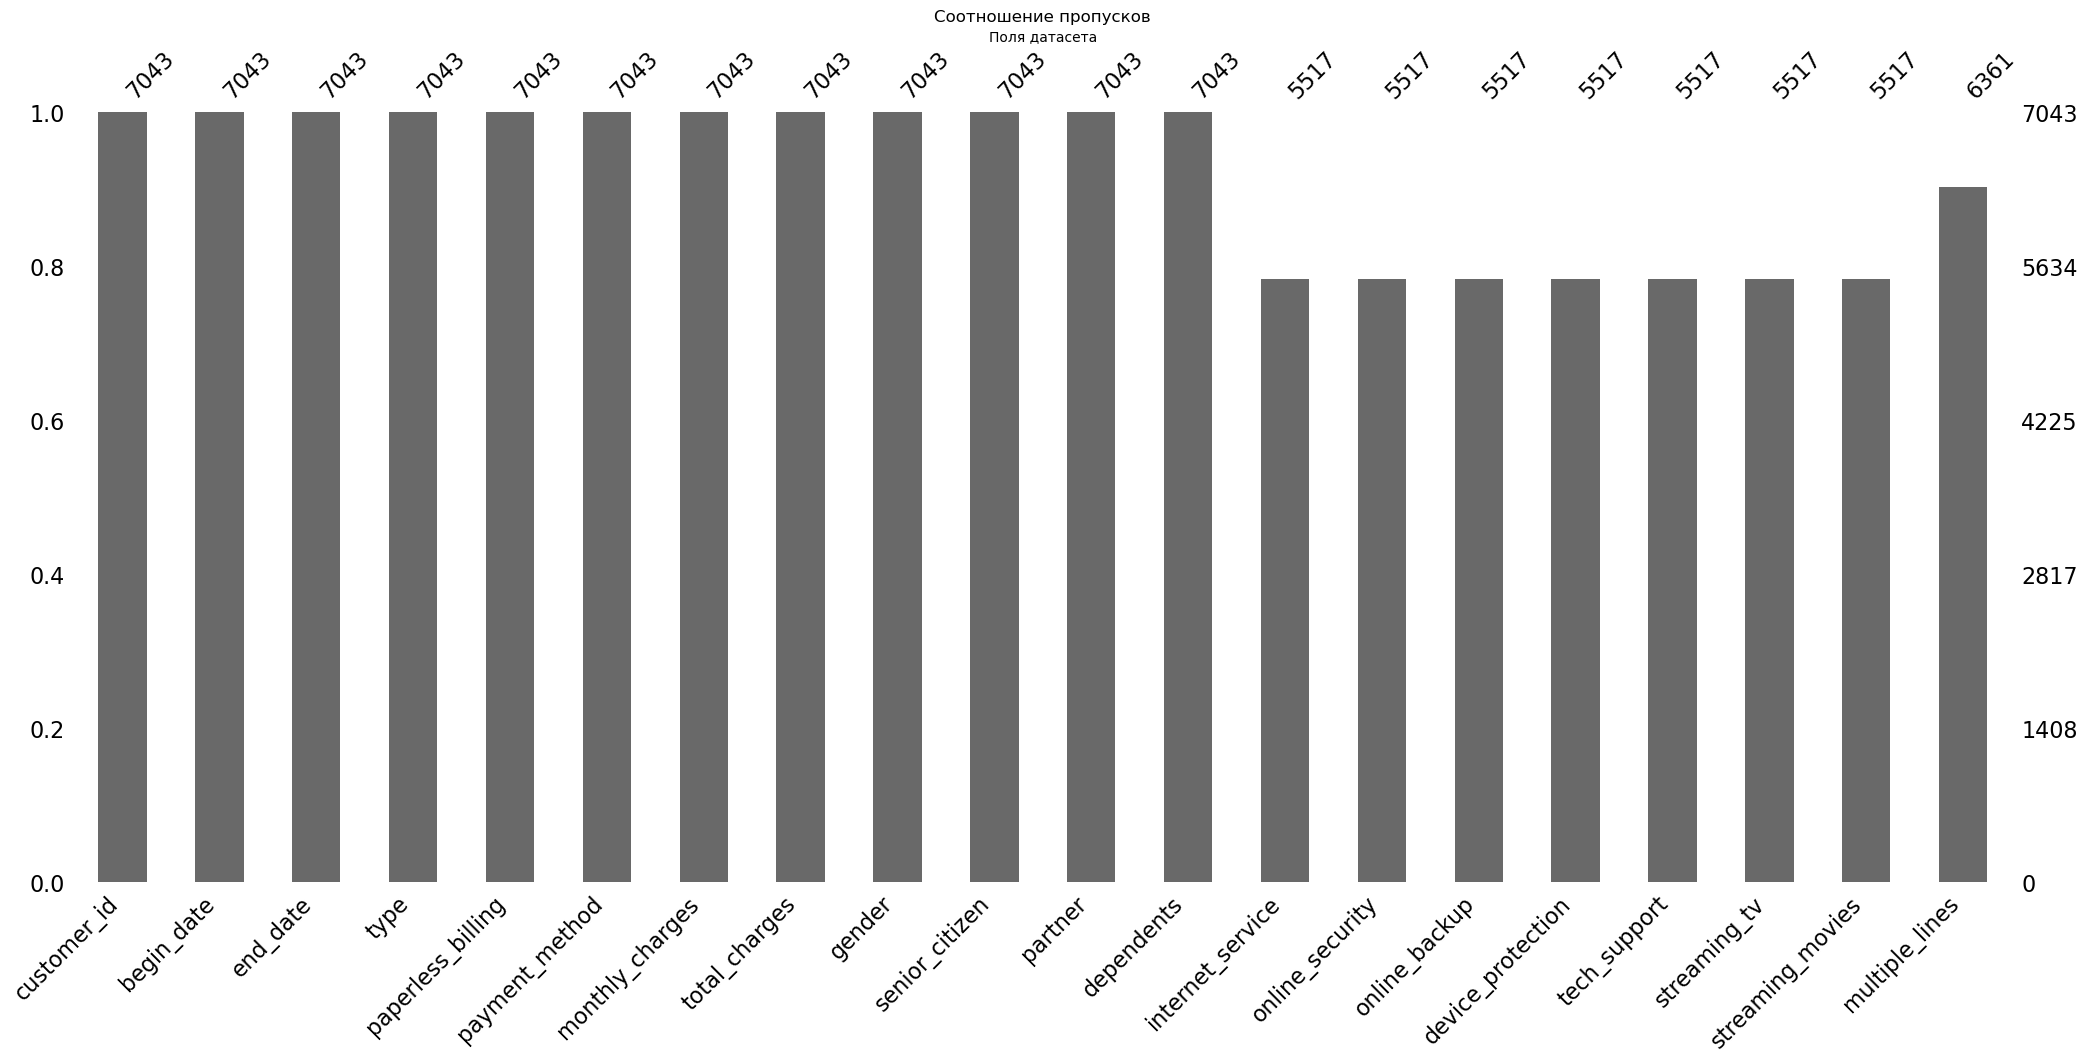

In [ ]:
msno.bar(df)
plt.title('Соотношение пропусков')
plt.ylabel('Количество')
plt.xlabel('Поля датасета')
plt.show()

В данном случае все предсказуемо, пропуски появились после объединение файлов в тех столбцах, где количество клиентов было меньше. Посмотрим дальше, что с ними можно сделать.

Пропуски в

online_security,     
online_backup,       
device_protection,  
tech_support,        
streaming_tv,       
streaming_movies,   
multiple_lines,

#### Выделим целевой признак по столбцу end_date

In [ ]:
df['end_date'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

In [ ]:
df['target'] = df['end_date'].apply(lambda x: 1 if x != 'No' else 0)

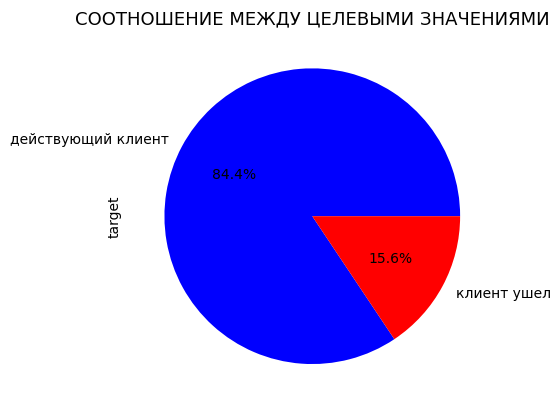

In [ ]:
df['target'].replace(1, 'клиент ушел').replace(0, 'действующий клиент').value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['b','r'])
plt.title('СООТНОШЕНИЕ МЕЖДУ ЦЕЛЕВЫМИ ЗНАЧЕНИЯМИ', size=13)
plt.show()


#### Обработаем пропуски

Итак, пропуски содержаться в online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines. Данные столбцы обозначают наличие услуг. Соответственно если у нас пропуск в значении, целесообразно заменить на отсутствующее значение. А так же нужно все аналогичные столбцы привести к единому формату.

In [ ]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


На данном этапе заменим все пропуски на 'NotUsed'

In [ ]:
df = df.fillna('NotUsed')

Все хорошо, с пропусками вопрос пока закрыт.

#### Преобразем данные

На данном этапе взгляд упал на два столбца begin_date и total_charges оба в object. Целесообразно поменять

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'])

In [ ]:
df[df['end_date'] =='No']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NotUsed,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NotUsed,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,Male,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Female,0,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,Female,0,...,Yes,DSL,Yes,No,No,No,No,No,NotUsed,0
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,Male,1,...,No,Fiber optic,No,No,No,No,No,No,Yes,0


Отсутствие даты заменим на 01.02.2020

In [ ]:
df['end_date'] = df['end_date'].replace('No', '01.02.2020')

In [ ]:
df['end_date'] = pd.to_datetime(df['end_date'])

В данных есть пробел как показала ошибка, посмотрим на данные.

In [ ]:
df[df['total_charges'] ==' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
488,4472-LVYGI,2020-02-01,2020-01-02,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NotUsed,0
753,3115-CZMZD,2020-02-01,2020-01-02,Two year,No,Mailed check,20.25,,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
936,5709-LVOEQ,2020-02-01,2020-01-02,Two year,No,Mailed check,80.85,,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-01-02,Two year,No,Mailed check,25.75,,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-01-02,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NotUsed,0
3331,7644-OMVMY,2020-02-01,2020-01-02,Two year,No,Mailed check,19.85,,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
3826,3213-VVOLG,2020-02-01,2020-01-02,Two year,No,Mailed check,25.35,,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,Yes,0
4380,2520-SGTTA,2020-02-01,2020-01-02,Two year,No,Mailed check,20.00,,Female,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
5218,2923-ARZLG,2020-02-01,2020-01-02,One year,Yes,Mailed check,19.70,,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
6670,4075-WKNIU,2020-02-01,2020-01-02,Two year,No,Mailed check,73.35,,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Удалять не будем, заменим на 0 и из объекта переведем в числовое значение.

In [ ]:
df['total_charges'] = df['total_charges'].replace(' ', 0)

In [ ]:
df['total_charges'] = pd.to_numeric(df['total_charges'])

In [ ]:
df[df['total_charges'] ==0]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
488,4472-LVYGI,2020-02-01,2020-01-02,Two year,Yes,Bank transfer (automatic),52.55,0.0,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NotUsed,0
753,3115-CZMZD,2020-02-01,2020-01-02,Two year,No,Mailed check,20.25,0.0,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
936,5709-LVOEQ,2020-02-01,2020-01-02,Two year,No,Mailed check,80.85,0.0,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-01-02,Two year,No,Mailed check,25.75,0.0,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-01-02,Two year,No,Credit card (automatic),56.05,0.0,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NotUsed,0
3331,7644-OMVMY,2020-02-01,2020-01-02,Two year,No,Mailed check,19.85,0.0,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
3826,3213-VVOLG,2020-02-01,2020-01-02,Two year,No,Mailed check,25.35,0.0,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,Yes,0
4380,2520-SGTTA,2020-02-01,2020-01-02,Two year,No,Mailed check,20.00,0.0,Female,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
5218,2923-ARZLG,2020-02-01,2020-01-02,One year,Yes,Mailed check,19.70,0.0,Male,0,...,Yes,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No,0
6670,4075-WKNIU,2020-02-01,2020-01-02,Two year,No,Mailed check,73.35,0.0,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


Все нормально, код сработал.

#### Добавим длительность контракта в днях

In [ ]:
#df['duration_month'] = ((df['end_date']-df['begin_date'])/np.timedelta64(1,'M')).astype(int)
#print(df['duration_month'])

In [ ]:
df['duration_day'] = ((df['end_date']-df['begin_date'])/np.timedelta64(1,'D')).astype(int)
print(df['duration_day'])

0          1
1       1006
2         93
3       1341
4        123
        ... 
7038     700
7039    2161
7040     307
7041     185
7042    1980
Name: duration_day, Length: 7043, dtype: int32


#### Корреляционный анализ данных

In [ ]:
phik_overview = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1).phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'lifetime'])
phik_overview.round(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,duration_day
type,1.00,0.11,0.28,0.39,0.47,0.00,0.09,0.18,0.15,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.09,0.77
paperless_billing,0.11,1.00,0.37,0.47,0.20,0.00,0.24,0.01,0.17,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.08,0.05
payment_method,0.28,0.37,1.00,0.40,0.34,0.00,0.29,0.24,0.22,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.21,0.47
monthly_charges,0.39,0.47,0.40,1.00,0.71,0.01,0.30,0.20,0.18,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.23,0.43
total_charges,0.47,0.20,0.34,0.71,1.00,0.00,0.14,0.38,0.08,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47,0.30,0.84
gender,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
senior_citizen,0.09,0.24,0.29,0.30,0.14,0.00,1.00,0.02,0.32,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.09,0.15
partner,0.18,0.01,0.24,0.20,0.38,0.00,0.02,1.00,0.65,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.23,0.47
dependents,0.15,0.17,0.22,0.18,0.08,0.00,0.32,0.65,1.00,0.11,0.12,0.10,0.09,0.11,0.09,0.08,0.01,0.05,0.23
internet_service,0.51,0.23,0.32,0.92,0.49,0.00,0.16,0.00,0.11,1.00,0.95,0.94,0.94,0.95,0.95,0.95,0.74,0.06,0.23


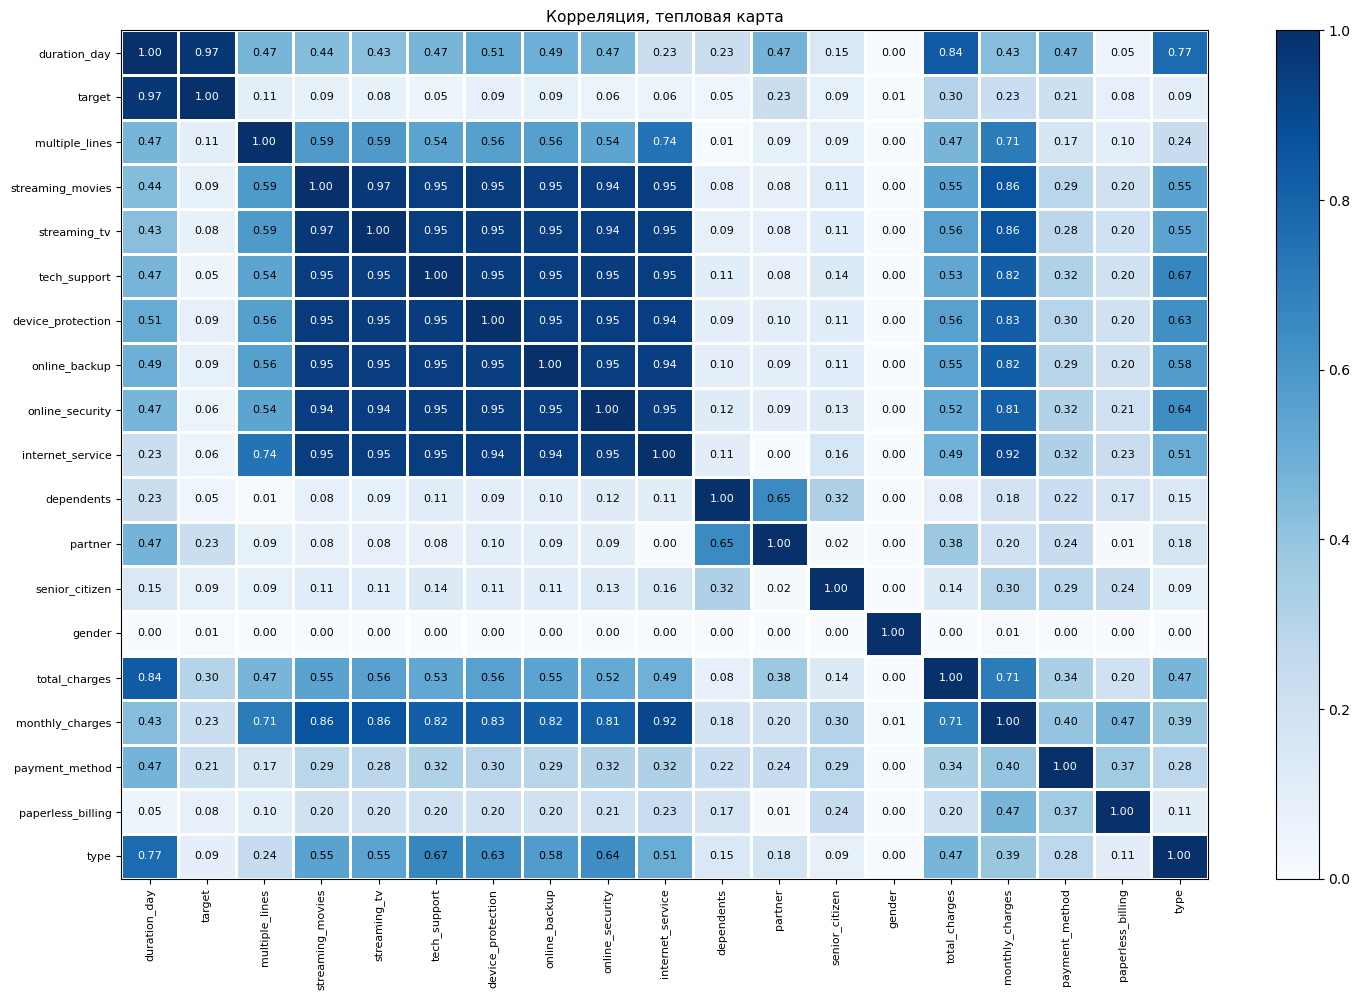

In [ ]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'Корреляция, тепловая карта', fontsize_factor=0.8,
                        figsize=(15,10.10))
plt.tight_layout()

На данном этапе проверим корреляцию на всем дата сете. Можно сделать первые выводы, пол клиента совершенно точно не влияет на корреляцию, так же нет зависимости как клиент получает счета. В дате начала так же видим высокую зависимость, но все же это мультиколлинеарность, в дальнейшем этот признак удалим. После полной пред обработки мы еще раз посмотрим корреляцию. Посмотрим на более интересные признаки, зависимость выручки принесенной клиентом и интернет сервис.

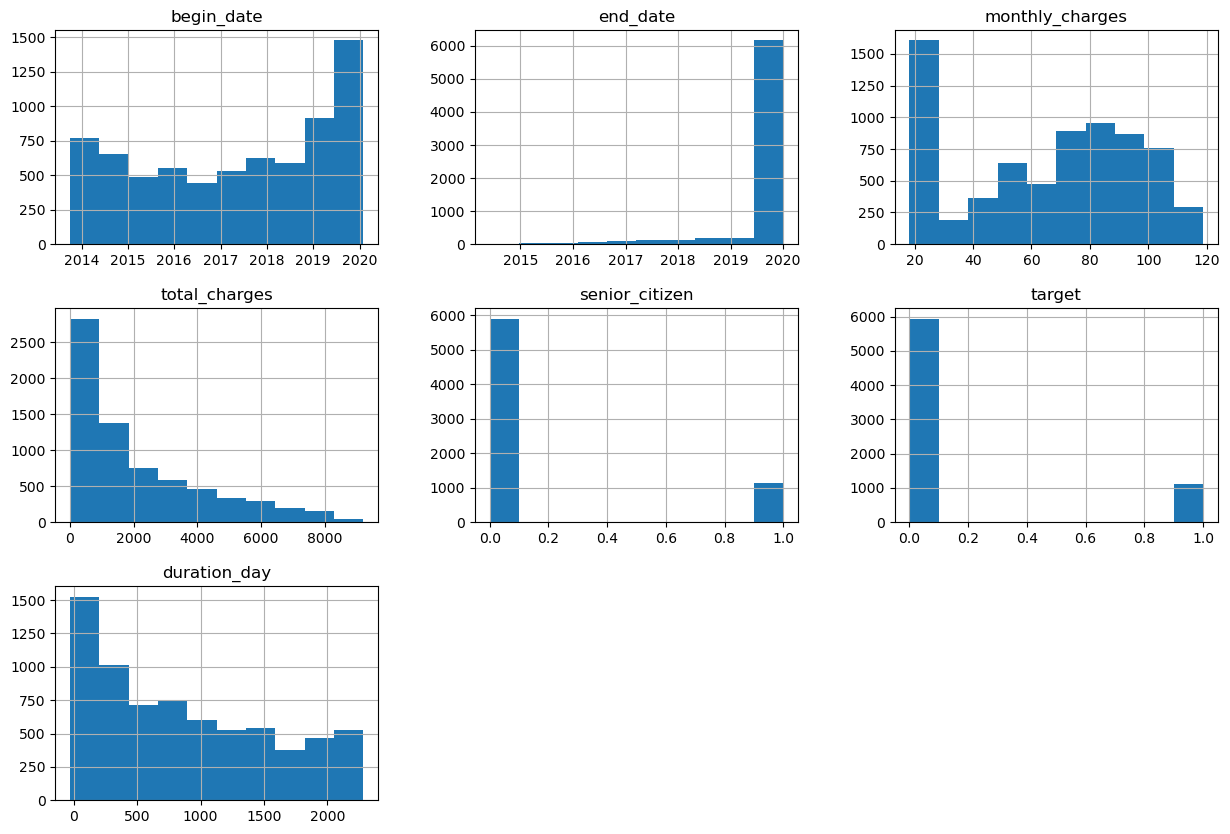

In [ ]:
df.query('internet_service != "No"').hist(figsize=(15,10))
plt.show()

Даты нам не несут ни какой информативности. Пенсионеров примерно четвертая часть. Большой всплеск в end_data в данном пункте у нас есть ограничение датой 01.02.2020, это объясняет такой всплеск. И все же на графике видно, что клиенты с компанией довольно продолжительное время.

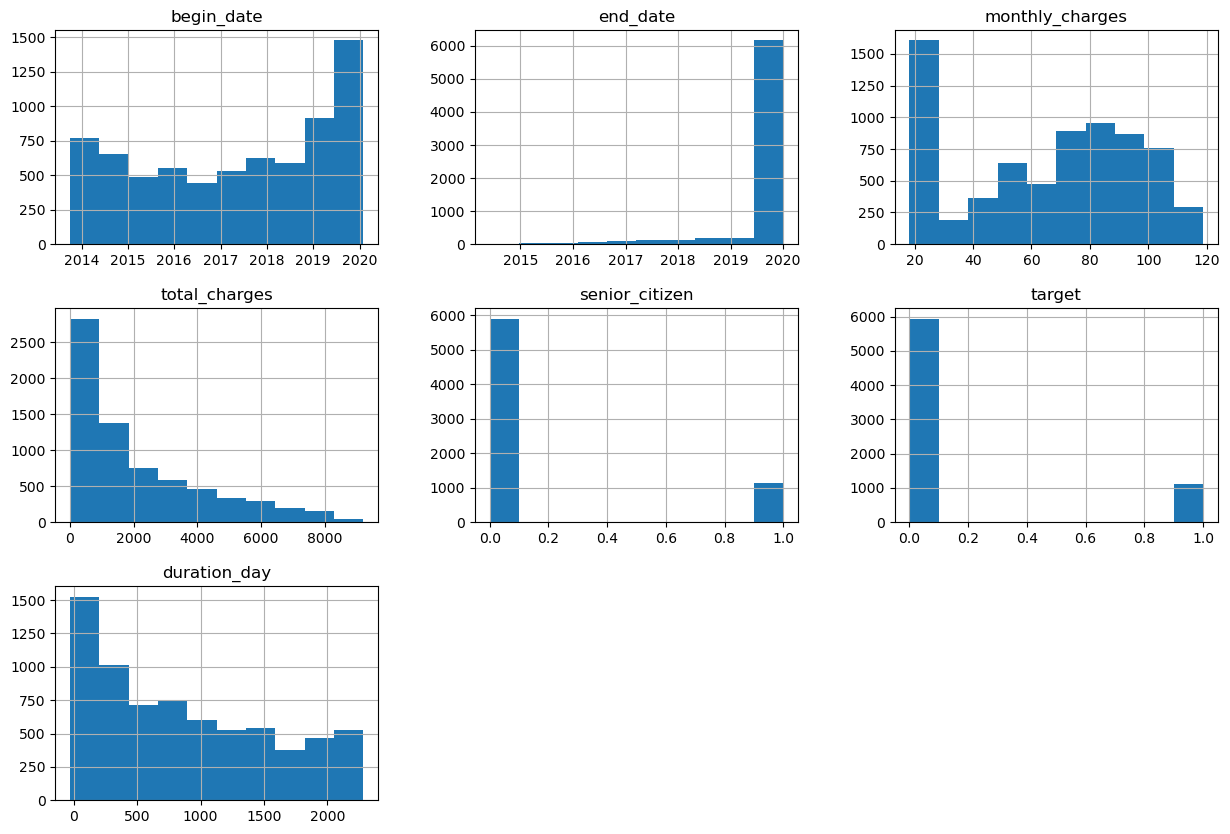

In [ ]:
df.query('total_charges != "0.0"').hist(figsize=(15,10))
plt.show()

В данном случае, как и признаком выше, мы видим почти точную схожесть. Каких то сюрпризов не видим. Идем дальше.

#### Удаляе не информативные признаки

In [ ]:
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

Признак senior_citizen хоть и представлен численым, по сути своей является дискретным и должен также кодироваться как категориальный признак - не факт, что сегодняшние 1 и 0 завтра не станут Yes и No (архитектуры хранилищ и способы хранения данных склонны меняться), и если этот момент не учесть в процессе подготовки данных, работа модели будет нарушена. Поэтому поменям.

In [ ]:
df['senior_citizen'] = df['senior_citizen'].astype('object')

In [ ]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,duration_day
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NotUsed,0,1
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1006
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,93
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NotUsed,0,1341
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,123


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

#### Вывод:

Файлы практически не повреждены, на первый взгляд пропуски отсутствовали, незначительные пропуски были в сумме оплаты, мы их заменили на значение 0, данный пропуск объясним, тем что клиент только к нам пришел. Были пропуски в датах, но это уже забегая вперед мы их ограничили 01.02.2020 годом. После объединения файлов у нас появились пропуски уже в значительном количестве, тоже логично объяснимо, в предоставленных таблицах разные данные. Тем самым логично было заменить пропуски на промежуточное значение 'NotUsed'. По признаку end_date вывели целевой признак, далее посмотрели соотношение действующих и ушедших клиентов, у нас получилось примерно 85/15, считаю вполне хороший показатель для компании. Следующим шагом добавили еще один признак продолжительности обслуживания клиентов в днях. Провели корреляционный анализ данных и сделали первые выводы. Посмотрели на более интересные признаки детально путем построения графиков. Удалили не информативные признаки. Следующим шагом продолжим пред обработку данных и соответственно дальнейшую работу по утвержденному плану.

### Обучение моделей

Посмотрим на оставшиеся признаки

In [ ]:
df.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'target', 'duration_day'],
      dtype='object')

#### Определим RANDOM_STATE

In [ ]:
RANDOM_STATE = 310723 #согласно утвержденному плану

#### Разделим на выборки 75/25 (3/1)

In [ ]:
features = df.drop('target', axis=1)
target = df['target']

In [ ]:

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target,
                                                                            shuffle = True)

In [ ]:
print('Обучающая выборка     _train', features_train.shape)
print('Тестовая выборка       _test', features_test.shape)

Обучающая выборка     _train (5282, 18)
Тестовая выборка       _test (1761, 18)


#### Кодируем признаки

Будем использовать модели леса и бустинга. Для этого достаточно будет использовать только OrdinalEncoder. Линейности в данных нет, так что логистическую модель использовать бесполезно.

In [ ]:
encoder = OrdinalEncoder()

In [ ]:
cat_columns = features_train.select_dtypes(include='object').columns.to_list()

In [ ]:
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [ ]:
features_train_ord.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_day
3995,0.0,1.0,0.0,74.90,734.77,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,273
388,0.0,1.0,3.0,90.40,4017.38,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,1310
3830,0.0,1.0,2.0,100.20,729.46,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,185
3239,0.0,1.0,3.0,49.45,791.20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,458
5574,0.0,0.0,2.0,20.45,838.45,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1218


#### Борьба с дисбалансом классов.

Используем StandardScaler

In [ ]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

scaler = StandardScaler()

scaler.fit(features_train_ord[num_features])
scaler.fit(features_test_ord[num_features])

features_train_ord[num_features] = scaler.transform(features_train_ord[num_features])
features_test_ord[num_features] = scaler.transform(features_test_ord[num_features])

features_train_ord.head()
features_test_ord.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_day
5924,2.0,0.0,1.0,-1.412364,-0.392358,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.421234
4662,0.0,0.0,1.0,-1.428677,-0.769878,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.349197
3580,0.0,1.0,3.0,0.292342,-0.549010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,-0.749254
3008,1.0,0.0,3.0,-1.433571,-0.886571,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.835084
708,0.0,1.0,1.0,0.370645,0.043424,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,-0.040790


In [ ]:
features_train_ord.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_day
3995,0.0,1.0,0.0,0.357594,-0.649299,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.884545
388,0.0,1.0,3.0,0.863297,0.896789,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.624031
3830,0.0,1.0,2.0,1.183031,-0.651800,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,-1.012563
3239,0.0,1.0,3.0,-0.472737,-0.622721,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,-0.615416
5574,0.0,0.0,2.0,-1.418890,-0.600466,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.490194


In [ ]:
features_test_ord.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,duration_day
5924,2.0,0.0,1.0,-1.412364,-0.392358,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.421234
4662,0.0,0.0,1.0,-1.428677,-0.769878,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.349197
3580,0.0,1.0,3.0,0.292342,-0.549010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,-0.749254
3008,1.0,0.0,3.0,-1.433571,-0.886571,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.835084
708,0.0,1.0,1.0,0.370645,0.043424,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,-0.040790


Все нормально данные закодировали и отмасштабировали, можем приступать к подбору гиперпараметров и обучению моделей.

#### Подбираем гиперпараметры, оцениваем модели на кросс-валидации

##### Модель Случайного леса RandomForestClassifier

In [ ]:
%%time

model_forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
#словарь с гиперпараметрами и значениями, которые хотим перебрать

parameters_forest = {'n_estimators': (300, 900, 100),
#                     'max_features': ['log2', 'sqrt'],
                    'max_depth': (2, 11, 2),
                    'min_samples_split': (2, 4),
                    'min_samples_leaf': (1, 3)}

#будем использовать RandomizedSearchCV, он работает на много быстрее
gs_forest = RandomizedSearchCV(model_forest, param_distributions=parameters_forest, cv=5, scoring='roc_auc', n_jobs=-1)

gs_forest.fit(features_train_ord, target_train)

ROC_AUC_forest = gs_forest.best_score_
best_params_forest = gs_forest.best_params_
best_model_forest = gs_forest.best_estimator_

CPU times: total: 4.69 s
Wall time: 16.2 s


In [ ]:
# лучшее значение ROC-AUC на кросс-валидации
print(f'ROC-AUC best_score: {ROC_AUC_forest}')
# лучшие гиперпараметры
print(f'best_params: {best_params_forest}')
print(f'best_model: {best_model_forest}')

ROC-AUC best_score: 0.8332126564109968
best_params: {'n_estimators': 900, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 11}
best_model: RandomForestClassifier(class_weight='balanced', max_depth=11,
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=900, random_state=310723)


Хороший результат для деревянной модели, быстрое обучение. Но не много не дотягивает до нужного значения

##### Модель LGBM Classifier (градиентный бустинг)

In [ ]:
%%time
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE )
#словарь с гиперпараметрами и значениями, которые хотим перебрать
parameters_lgbm = {'boosting_type': ['gbdt', 'goss'],
                    'importance_type': ['split', 'gain'],
                    'learning_rate': [0.1, 0.15],
                    'max_depth': [1, 3, 5],
                    'n_estimators': [200, 400]}


#будем использовать RandomizedSearchCV, он работает на много быстрее
gs_lgbm = RandomizedSearchCV(model_lgbm, parameters_lgbm, cv=3, scoring='roc_auc', n_jobs=-1)

gs_lgbm.fit(features_train_ord, target_train)

ROC_AUC_lgbm = gs_lgbm.best_score_
best_params_lgbm = gs_lgbm.best_params_
best_model_lgbm = gs_lgbm.best_estimator_

CPU times: total: 406 ms
Wall time: 2 s


In [ ]:
# лучшее значение ROC-AUC на кросс-валидации
print(f'ROC-AUC best_score: {ROC_AUC_lgbm}')
# лучшие гиперпараметры
print(f'best_params: {best_params_lgbm}')
print(f'best_model: {best_model_lgbm}')

ROC-AUC best_score: 0.879917428061126
best_params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.15, 'importance_type': 'gain', 'boosting_type': 'gbdt'}
best_model: LGBMClassifier(importance_type='gain', learning_rate=0.15, max_depth=3,
               n_estimators=200, random_state=310723)


Параметры подобрались хорошо, модель так же отработала на отлично и быстро, результат достигнут.

##### Модель CatBoost Classifier (градиентный бустинг)

In [ ]:
%%time
model_catboost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
#словарь с гиперпараметрами и значениями, которые хотим перебрать
parameters_catboost = {'iterations': [300, 450, 600],
                       'depth': [2, 4, 6,],
                       'learning_rate': [0.15, 0.2]}

#будем использовать RandomizedSearchCV, он работает на много быстрее
gs_catboost = GridSearchCV(model_catboost, parameters_catboost, cv=3, scoring='roc_auc', n_jobs=-1)

gs_catboost.fit(features_train_ord, target_train)

CPU times: total: 5.44 s
Wall time: 12.2 s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000210ABB417B0>,
             n_jobs=-1,
             param_grid={'depth': [2, 4, 6], 'iterations': [300, 450, 600],
                         'learning_rate': [0.15, 0.2]},
             scoring='roc_auc')

In [ ]:
ROC_AUC_catboost = gs_catboost.best_score_
best_params_catboost = gs_catboost.best_params_
best_model_catboost = gs_catboost.best_estimator_

In [ ]:
# лучшее значение ROC-AUC на кросс-валидации
print(f'ROC-AUC best_score: {ROC_AUC_catboost}')
# лучшие гиперпараметры
print(f'best_params: {best_params_catboost}')
print(f'best_model: {best_model_catboost}')

ROC-AUC best_score: 0.9281722236777382
best_params: {'depth': 4, 'iterations': 600, 'learning_rate': 0.2}
best_model: <catboost.core.CatBoostClassifier object at 0x00000210ABB42AA0>


Немного дольше, но и результат лучше.

#### анализируем результаты моделей

In [ ]:

index = ['Случайный лес',
         'LGBM Classifier',
         'CatBoostClassifier']

data = {'ROC-AUC': [ROC_AUC_forest,
                    ROC_AUC_lgbm,
                    ROC_AUC_catboost]}

rating = pd.DataFrame(data=data, index=index)
rating.sort_values(by='ROC-AUC', ascending=False)

,ROC-AUC
CatBoostClassifier,0.928172
LGBM Classifier,0.879917
Случайный лес,0.833213


#### Вывод:

Параметр RANDOM_STATE был определен заранее, как и размер выборок в соотношении 75/25. Для выполнения задания принято решение использовать три модели, одна из которых случайный лес, две остальные модели градиентного бустинга. Для их обучения мы применили кодирование OrdinalEncoder, данное кодирование рекомендовано для использования в работе данными моделями и отмасштабировали данные. Подбор гиперпараметров сделали с помощью RandomizedSearchCV, данный метод уже хорошо себя зарекомендовал в других подобных задачах и работает быстрее чем остальные. Собственно данный метод справился со своей задачей на отлично. Модели градиентного бустинга с задачей справились лучше, чем деревянная модель. Результат отражен в пункте 2.6. Временные затраты моделей практически одинаковы, однако лучший показатель у модели CatBoost, ее и отправляем тестировать.

### Тестируем лучшую модель

На тест отправляем лучшую модель по показателю ROC-AUC

#### CatBoost показатель ROC-AUC 0.928

In [ ]:
# проверка на тестовой выборке CatBoostClassifier
y_pred_proba = best_model_catboost.predict_proba(features_test_ord)[:, 1]

y_prediction = best_model_catboost.predict(features_test_ord)
accuracy_catboost_test = accuracy_score(target_test, y_prediction)

roc_auc_catboost_test = roc_auc_score(target_test, y_pred_proba)
print('Модель CatBoostClassifier на тестовой выборке')
print(f'ROC-AUC: {roc_auc_catboost_test}')
print(f'Accuracy: {accuracy_catboost_test}')

Модель CatBoostClassifier на тестовой выборке
ROC-AUC: 0.9459121497614095
Accuracy: 0.9403747870528109


Отлично, модель справилась с поставленной задачей, показатель ROC-AUC более 0.94. Метрика установлена заказчиком.

Метрика accuracy- это доля правильных ответов, другими словами, это отношение числа правильных ответов к общему размеру тестовой выборки. В нашем случае метрика равно 0.94, т е 94% правильных ответов предсказано верно.

**Пояснения**

ROC-кривая – это кривая вероятности, которая отображает отношение TPR(верно спрогноированных ушедших клиентов) к FPR (прогноз, что клиент уйдет, а он остался) при различных пороговых значениях и по существу отделяет «сигнал» от «шума». Площадь под кривой (AUC) является мерой способности классификатора различать классы. Чем выше площадь под кривой, тем лучше производительность модели.

#### AUC-ROC и анализируем матрицы ошибок.

In [ ]:
#построение ROC кривой и расчет AOC-ROC
def roc(model):
    probabilities_test = model.predict_proba(features_test_ord) #значение вероятностей
    probabilities_one_test = probabilities_test[:, 1] #вероятности со значением 1

    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr) #построение графика
    plt.plot([0,1],[0,1],linestyle = '--') #ROC-кривая случайной модели
    plt.xlim([0.0, 1.0]) #установка грани осей от 0 до 1
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая модели Catboost')
    plt.show()
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    print("AUC_ROC модели Catboost:", auc_roc)

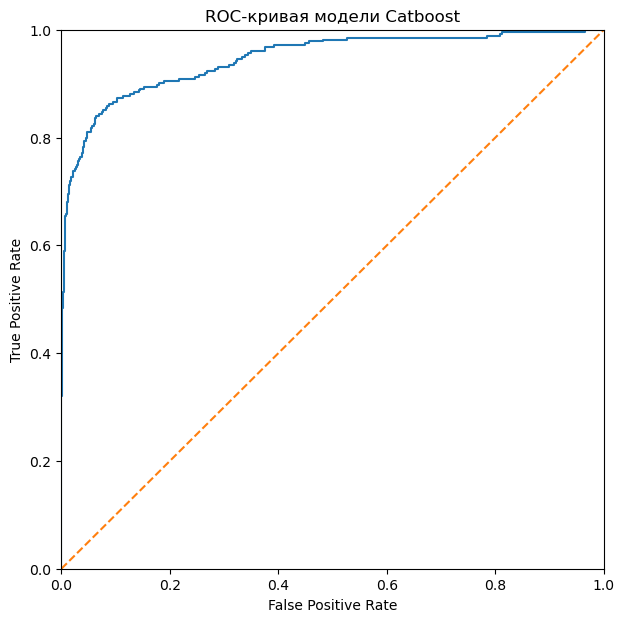

AUC_ROC модели Catboost: 0.9459121497614095


In [ ]:
#ROC кривая для модели catBoost
roc(best_model_catboost)

Результат на тесте оказался чучше нем на обучении. Хороший результат.

Confusion matrix, without normalization
[[1469   17]
 [  88  187]]


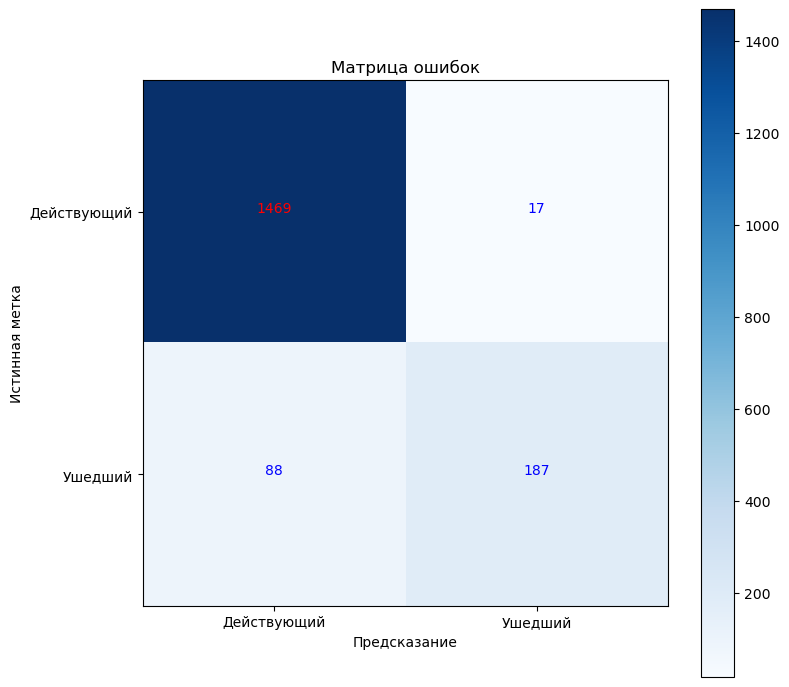

In [ ]:
# строим матрицу ошибок

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='red' if cm[i, j] > thresh else 'blue')

    plt.tight_layout()
    plt.ylabel('Истинная метка')
    plt.xlabel('Предсказание')

    font = {'size' : 10}
    plt.rc('font', **font)

cnf_matrix = confusion_matrix(target_test, best_model_catboost.predict(features_test_ord))
plt.figure(figsize=(8, 7))
plot_confusion_matrix(cnf_matrix, classes=['Действующий', 'Ушедший'],
                  title='Матрица ошибок')
plt.show()

Высокие показатели tp и tn свидетельсвуют о том, что модель имеет хорошую предсказательную способность. Об этом же свидетельвые высокое значение accuracy = 0.94

В матрице ошибок есть четыре возможных исхода:

+ True Positive (TP) = 1469: Модель правильно предсказала клиент останется (положительный класс).
+ True Negative (TN) = 17: Модель правильно предсказала, что клиент уйдет (отрицательный класс).
+ False Positive (FP) = 88: Модель неправильно предсказала уход, хотя клиент остался (ложное срабатывание).
+ False Negative (FN) = 187: Модель неправильно предсказала, что клиент останется, хотя он ушел (пропущенный случай).

#### Построим график важности признаков

In [ ]:
best_features_importance = best_model_catboost.feature_importances_
print(best_features_importance)

[ 5.06460349  0.74752143  2.89755684 10.19732024 10.92014916  0.87616741
  1.27587479  2.31478276  1.37529137  1.79509654  1.1049531   1.40820281
  1.20402089  0.96579002  0.66712302  1.50099153  2.12073669 53.56381789]


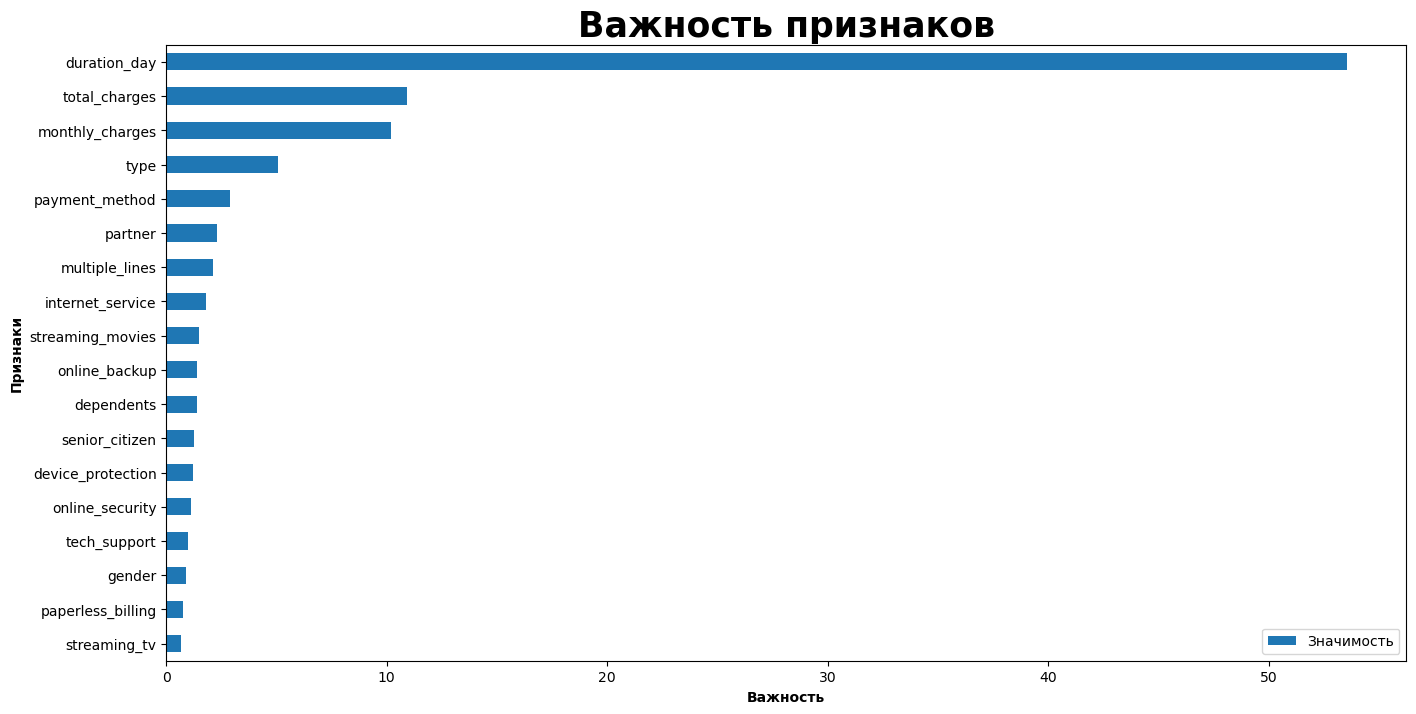

In [ ]:
pd.DataFrame(data={
          'Поле': features_test_ord.columns,
          'Значимость': best_features_importance
      }
            ).set_index('Поле').sort_values(by='Значимость').plot(kind='barh',figsize = (16,8))
plt.title('Важность признаков', fontsize=25, weight = 'bold')
plt.xlabel('Важность', weight = 'bold')
plt.ylabel('Признаки', weight = 'bold')
plt.show()

Наиболее сильное влияние на уход клиента оказывает продолжительность договора, сумма оплаты и ежемесячная оплата.

#### Вывод:

Протестировав лучшую модель на тестовой выборке метрика ROC-AUC показала более высокий результат чем на обучающей выборки. Мы добились хорошего значения метрики ROC-AUC 0.94. Наша модель справилась с задачей. Построение ROC-Кривой, нам показал хорошую площадь охвата. Матрица ошибок, так же показала хорший результат.
На графике Важности признаков отражено наглядно, что на уход клиента прежде всего влияет срок обсуживания клиента и ежемесячная оплата.

### Итоговый вывод


1. Произведен **предварительный анализ и преобразование данных**, по результатам которых:

- установлено, что в данных отсутствуют дубликаты;
- данные приведены в соответствие с PEP-8;
- типы данных приведены в соответствие с содержанием;
- данные объединены по столбцу customer_id;
- пропуски заполнены;
- добавлены новые столбцы;
- Произведен EDA, по результатам которого было установлено, что целевой признак имеет крайне слабую или нулевую корреляцию с другими признаками.
- удалены нерелевантные для дальнейшей работы столбцы;

2. На этапе **предобработки и обучения моделей**:
- данные разделены на обучающую и тестовую выборки;
- данные закодированы с помощью Ordinal Encoding;
- гиперпараметры подобраны методом GridSearchCV;
- для обучения выбраны три модели
- лучшую метрику ROC_AUC продемонстрировал ROC_AUC CatBoost Classifier: 0.945


3. **Тестирование** CatBoost Classifier по метрике ROC-AUC на тестовой выборке показало значение = 0,94;
- согласно графику ROC-кривой, модель демонстрирует хорошую способность различения классов
- матрица ошибок и значение метрики accuracy (0,94) с высокими показателями true positive и true negative свидетельсвуют о том, что модель имеет хорошую предсказательную способность и может применяться для искомой задачи - предсказания оттока клиентов.
- анализ важности признаков показал, что наиболее негативно на предсказательной способности модели сказываются продолжительность пользования услугами и сумма оплаты, а так же способ оплаты.

Считаю данную модель рабочей и можно использовать использовать в дальнейших задачах.

С уважением,
А. Нестеров.



### Отчет

1. Произведен **предварительный анализ и преобразование данных**, по результатам которых:

- установлено, что в данных отсутствуют дубликаты;
- данные приведены в соответствие с PEP-8;
- выделен целевой признак target на основе столбца end_date: если человек ушел присваивается 1, если не ушел - 0;
- добавлены новые столбцы (период пользования услугами компании в днях);
- данные объединены по столбцу customer_id:

После объединения:

- пропуски заполнены:
- после объединения часть данных отсутсвовала, так как клиенты не пользовались опредленными услугами, пропущенные данные были заполнены на основании услуг (NotUsed).
  
- Произведен EDA, по результатам которого было установлено, что:

- В корреляционной матрице отмечается наиболее сильная корреляция между продолжительностью пользования услугами в общем и общими платежами. Обе услуги демонстрируют высокую степерь корреляции с monthly_charges, особенно internet_servies, так как подбные услуги часто оплачиваются помесячно. Объяснима и корреляция internet_servies с услугами, предоставляемыми посредством интернета (стриминговые сервисы и тд). Есть корреляция иждивенцев с наличием партнера(супруга), однако с целевым признаком корреляция слабая. Целевой признак имеет крайне слабую или нулевую корреляцию с другими признаками.

2. На этапе **предобработки и обучения моделей**:
- Определены итоговые признаки для обучения моделей
  - type - тип оплаты
  - paperless_billing - электронный чек
  - payment_method - способ оплаты
  - monthly_charges - ежемесячная оплата
  - total_charges - общие расходы
  - gender - пол
  - senior_citizen - пенсионный статус
  - partner - семейное положение
  - dependents - иждевенцы
  - internet_service - наличие интернета
  - online_security - охрана
  - online_backup - облачное хранилище
  - device_protection - защита  
  - tech_support - техническая поддержка
  - streaming_tv - подписка ТВ
  - streaming_movies - подписка фильмы
  - multiple_lines - многоканальный телефон
  - duration_day - подолжительность обслуживания в днях

- данные разделены на обучающую и тестовую выборки (3:1);
- удалены нерелевантные для дальнейшей работы столбцы, из-за которых может произойти утечка данных
- данные закодированы с помощью Ordinal Encoding;
- признаки разделены на: категориальные, численные.
  
Для подбора гиперпараметров использован GridSearchCV c метрикой ROC_AUC. Данная метрика является наиболее подходящей, так как она не чувствительная к дисбалансу классов.

Лучшую метрику ROC_AUC продемонстрировал CatBoost. Оценка моделей на кросс валидации:

ROC_AUC CatBoostClassifier	0.928172
ROC_AUC LGBM Classifier	0.879917
ROC_AUC Случайный лес	0.833213

3. Тестирование CatBoostr по метрике ROC-AUC на тестовой выборке, полученное значение = 0,94 с параметрами depth: 4, iterations: 600, learning_rate: 0.2

- согласно графику ROC-кривой, модель демонстрирует хорошую способность различения классов: кривая находится значительно выше дамми-модели;

- матрица ошибок и значение метрики accuracy (0,94) с высокими показателями true positive и true negative свидетельсвуют о том, что модель имеет хорошую предсказательную способность.

- True Positive (TP) = 1469: Модель правильно предсказала клиент останется (положительный класс).
- True Negative (TN) = 17: Модель правильно предсказала, что клиент уйдет (отрицательный класс).
- False Positive (FP) = 88: Модель неправильно предсказала уход, хотя клиент остался (ложное срабатывание).
- False Negative (FN) = 187: Модель неправильно предсказала, что клиент останется, хотя он ушел (пропущенный случай).


- анализ важности факторов показал, что важнейшим является продолжительность пользования услугами: **лояльные клиенты менее склонны к уходу**. Среди факторов, влияющих **на решение клиента остаться** также можно отметить **наличие супруга(супруги), пользование услугами межсетевого экрана, антивируса, облачного хранилища и выставления счета по электронной почте**. Помимо этого, роль играет и **наличие иждивенцев и возможность подключения телефона к нескольким линиям**. **К уходу**, в свою очередь, **более склонны клиенты**, которые **платят за интернет помесячно**: чем выше ежемесячный платеж, тем больше вероятность смены провайдера. Также к уходу склонны те, кто платит электорнными чеками.


Ключевые шаги:

- предварительный анализ и преобраование данных
- выделение признаков
- предобработка и анализ данных
- подбор гиперпараметров с помощью GridSearchCV
- тестирование модели c лучшей метрикой ROC_AUC

Работа выполнена в соответствии с планом, отклонений не было.

В ходе работы возникли сложности с кодированием категориальных признаков.

1.Подготовка данных
Загрузка и ознакомление с данными
преобразование данных:
приведение к змеиному синтаксису и к соответствующим типам данных
объединение данных в единый датафрейм
выделение целевого признака
работа с пропусками дубликатами
EDA

2. определение RANDOM_STATE = 310723
Разделение на выборки (3:1)
Кодирование (OrdinalEncoder)
Удаление признаков
Обучение моделей
Подбор гиперпараметров на кроссвалидации с GridSearchCV для:
1) Random Forest 2) LightGBM 3) CatBoost

Обучение моделей и выбор лучшей на основании лучшего показателя (по метрике на кроссвалидации model.bestscore после GridSearchCV)
Тестирование лучшей модели по метрике ROC-AUC на тестовой выборке (+ вывести ROC-кривую, посчитать accuracy, вывести матрицу ошибок и важность признаков)

Выводы и рекомендации для бизнеса

Модель может быть применена для решения посталенной задачи - предсказание оттока клиентов.
Возможно учучшение за счет добавления и тестирования дополнительных гиперпараметров.